In [1]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import pysindy as ps

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt

c:\Users\Joost\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = r"data\\"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
OGDATA = "OG-1-1-11"
# change data set
DATA = OGDATA
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

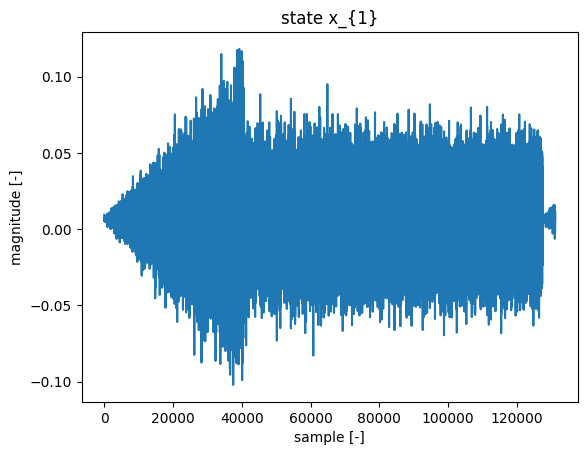

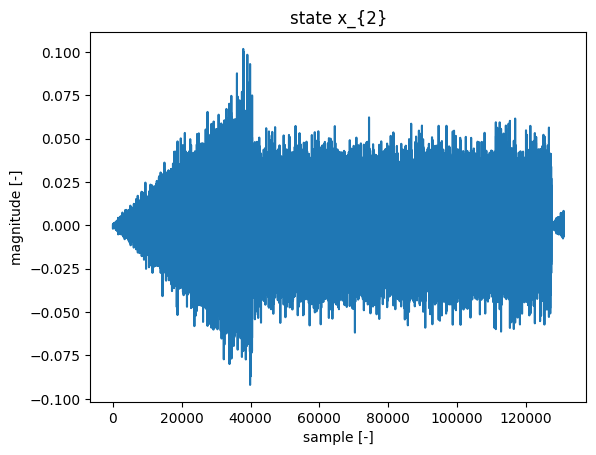

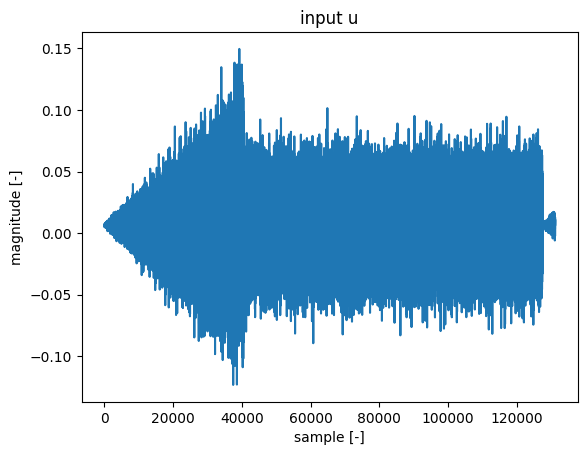

In [3]:
# data
x1 = data[:,0]
x2 = data[:,1]
u = data[:,2]

N = x1.shape[0]
fs = 610.35
dt = 1/fs
t = np.linspace(0,dt*N,N)

plt.plot(x1)
plt.xlabel("sample [-]")
plt.ylabel("magnitude [-]")
plt.title("state x_{1}")
plt.show()

plt.plot(x2)
plt.xlabel("sample [-]")
plt.ylabel("magnitude [-]")
plt.title("state x_{2}")
plt.show()

plt.plot(u)
plt.xlabel("sample [-]")
plt.ylabel("magnitude [-]")
plt.title("input u")
plt.show()

In [53]:
silver_data = System_data(u=u,y=np.stack((x1, x2), axis=-1))

train, test = silver_data[40000:], silver_data[:40000]
print("Training samples: ", train.y.shape[0])
print("Test samples: ", test.y.shape[0])

time = t[0:train.y.shape[0]]

Training samples:  91072
Test samples:  40000


In [54]:
norm_train = (train.y-np.mean(train.y))/np.std(train.y)

In [6]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

In [38]:
# differentiation_method = ps.SINDyDerivative(kind="spline", s=1e-2)
differentiation_method = ps.FiniteDifference(order=4)

x_train = train.y

# model specs
feature_library = ps.ConcatLibrary([ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ(alpha=200, verbose=True)#, threshold= 0.03

model = ps.SINDy(feature_library=feature_library,
                 optimizer=stlsq_optimizer
                 )

t_train = np.linspace(0,dt*train.y.shape[0],train.y.shape[0])
# fit
model.fit(x_train, u=train.u, t=t_train)
model.print()
model.coefficients()

x_test = test.y
x_dot_test_predicted = model.predict(x_test, u=test.u)

# t_test = np.linspace(0,dt*test.y.shape[0],test.y.shape[0])
# x_dot_test_simulated = model.simulate(x_test[0], u=test.u, t=t_test)

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 8.0539e+06 ... 1.1077e+06 ...         13 ... 9.1615e+06
         1 ... 8.0544e+06 ... 1.1071e+06 ...         13 ... 9.1615e+06
(x0)' = -0.206 1 + -34.150 x0 + 424.981 x1 + 67.464 u0 + 1.204 x0 x1 + -7.054 x0 u0 + 6.982 x1 u0 + -0.444 u0^2
(x1)' = -316.391 x0 + -112.992 x1 + 244.174 u0 + 244.908 x0^2 + 198.037 u0^2


NRMS pred 1:  369.921855157504
NRMS simo 1:  0.6010057635585481


ValueError: operands could not be broadcast together with shapes (39999,) (40000,) 

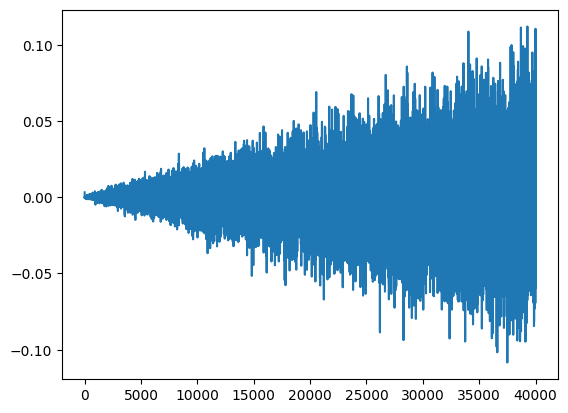

In [10]:
pred_NRMS = NRMS( x_dot_test_predicted[:-1,0], test.y[1:,0])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], test.y[:-1,0])

print("NRMS pred 1: ",pred_NRMS)
print("NRMS simo 1: ",simo_NRMS)

plt.plot(test.y[:,0]-np.mean(test.y[:,0]))
plt.plot(x_dot_test_predicted[:-1,0]-test.y[:,0])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(test.y[:,0]-np.mean(test.y[:,0]))
plt.plot(x_dot_test_simulated[:,0]-test.y[:,0])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Simulation, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()

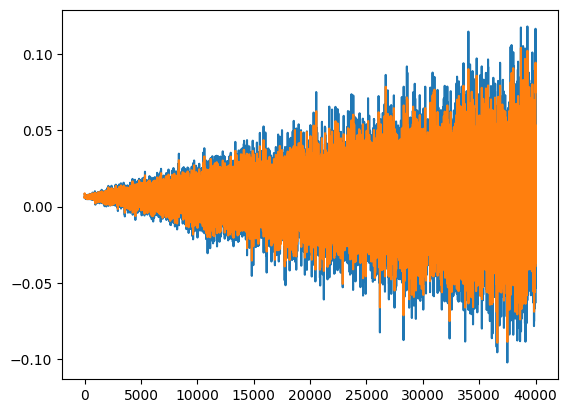

In [44]:
plt.plot(test.y[1:,0])
plt.plot(test.y[1:,0]-x_dot_test_predicted[:-1,0]/400)
# plt.plot(x_dot_test_simulated[:200,0]-np.mean(x_dot_test_simulated[:200,0]))
